# Week 5 exercise: Simple MD simulations

In this session we will implememnt simple MD simulations of increasing complexity.

- Implement a numerical simulation of the dynamics of an Harmonic oscillator, using the verlet algorithm to integrate the equations of motion. 

Using this notebook as a starting point (also accessible on [Google colab](https://colab.research.google.com/drive/1kTwPnugWLoW7Y54JK4msnLYayx4Powvb?usp=sharing)): 

- Implement a dynamic simulation of an ideal gas in 2D. 

- Introduce an interaction $\Gamma_{ii}(r)=r^{-2}$ potential to model a system of _soft_ spheres, in a box defined by harminic repulsive walls. 

- Introduce a Lennard Jones interaction potential. 

- Observe what happens by performing simulations at different values of $\epsilon$

- Introduce harmonic potentials to model diatomic molecules. 




# 1D Harmonic Oscillator
## System Setup

In [34]:
%matplotlib inline
## Import libraries to plot and do math
import matplotlib.pyplot as plt 
import numpy as np

## Setup parameters of the HA
m=1.0; #mass
k=5; #Harmonic Constant
req=1.5; #Equilirbium 
##

## Set the initial Conditions
r0=1.0; # Initial position
v0=.5;  # Initial velocity

## Define the timestep and the total time
dt=0.01; #timestep
total_time=50; 
# Compute the total number of steps
nsteps=int(total_time/dt); # Total number of steps

## Initialise vectors 
v=np.zeros(nsteps)
r=np.zeros(nsteps)
time=np.zeros(nsteps)
POT=np.zeros(nsteps)
KIN=np.zeros(nsteps)

## Definition of useful functions. 

### Calculation of the force and potential energy

The force is computed as the negative of the potential derivative with respect to the degree of the degree of freedom. 

The potential is $V(r(t))=\frac{1}{2}k(r(t)-req)^2$, hence the force is: 

$$
F(t)=-\frac{\partial{V(r(t))}}{\partial{r(t)}}=-k(r(t)-req)
$$ 

In the code below the function computing the force is implemented as: 

```force=lambda r, k, req, : -k*(r-req)```

and the function computing the potential energy is defined as: 

```energy_pot=lambda r, k, req: 0.5*k*np.power(r-req,2)```

### Calculation of the velocity and kinetic energy

The velocity at time $t$, $v(t)$ is computed as: 

$$v(t)=\frac{r(t+\Delta{t})-r(t-\Delta{t})}{2\Delta{t}}$$ 

```velocity=lambda r, r_past, dt: (r-r_past)/2/dt```

The kinetic energy $K(v)=\frac{1}{2}mv^2$

```energy_kin=lambda v, m: 0.5*m*np.power(v,2)```

### Propagation of the system's dynamics: 

We use the Verlet algorithm: 

$$
r(t+\Delta{t})=2r(t)-r(t-\Delta{t})+\frac{F(t)}{m}\Delta{t}^2
$$

implemented as: 

```verlet=lambda r, r_past, force, mass, dt:  2*r-r_past+(dt**2)*force/mass```

In [35]:
## Useful functions
force=lambda r, k, req, : -k*(r-req)
energy_pot=lambda r, k, req: 0.5*k*np.power(r-req,2)
velocity=lambda r, r_past, dt: (r-r_past)/2/dt
energy_kin=lambda v, m: 0.5*m*np.power(v,2)
verlet=lambda r, r_past, force, mass, dt:  2*r-r_past+(dt**2)*force/mass

# initialise position and velocity

time[0]=0;
time[1]=dt;
v[0]=v0;
r[0]=r0;
r[1]=r[0]+v[0]*dt
v[1]=velocity(r[0],r[1],dt);

for i in np.arange(0,2):
    POT[i]=energy_pot(r[i],k,req)
    KIN[i]=energy_kin(v[i],m)

### Compute Trajectory

Propagate the dynamics with the Verlet algorithm :

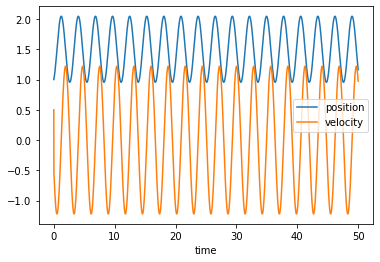

In [36]:
# Compute trajectory
for ts in np.arange(1,nsteps-1): #Cycle over timesteps
    
    f=force(r[ts],k,req) # Compute the force 
     
    r[ts+1]=verlet(r[ts],r[ts-1],f,m,dt) # Compute the next position
    time[ts+1]=time[ts]+dt # update the clock
    
    v[ts]=velocity(r[ts-1],r[ts+1],dt) # compute the velocity     
    POT[ts]=energy_pot(r[ts],k,req)  # compute the Potential Energy     
    KIN[ts]=energy_kin(v[ts],m)      # compute the Kinetic Energy    
    
v[ts+1]=v[ts]

plt.plot(time,r,label='position');
plt.plot(time,v,label='velocity');
plt.legend();
plt.xlabel('time');


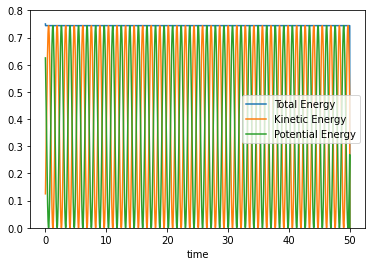

In [37]:
# Conservation of energy
plt.plot(time,POT+KIN,label='Total Energy')
plt.plot(time,KIN,label='Kinetic Energy')
plt.plot(time,POT,label='Potential Energy')
plt.ylim([0, np.max(POT+KIN)+0.05])
plt.legend()
plt.xlabel('time');

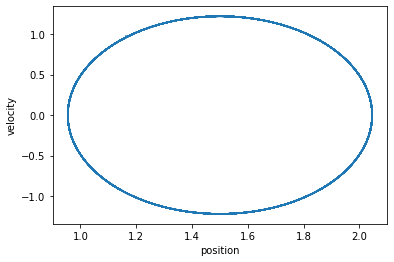

In [38]:
# Motion in phase space
plt.plot(r[10:],v[10:])
plt.xlabel('position');
plt.ylabel('velocity');

In [56]:
%%capture
# Visualize trajectory
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML


# Animate the results
def init():
    line.set_data([], [])
    return (line,)

fig, ax = plt.subplots(figsize=(8, 5))

#ax.set_xlim(( 0, total_time))
ax.set_xlim(-(np.max(r)/2+0.1*np.max(r)), np.max(r)/2+0.1*np.max(r))
line, = ax.plot([], [], lw=2, marker='o', markersize=45, markerfacecolor=(0.8, 1.0, 0.8, 0.5),
             markeredgewidth=1,  markeredgecolor=(0, 0, 0, .5), linestyle='-.',color='r')

def animate(i):
    x = np.array([-r[i]/2,r[i]/2])
    y = np.array([0,0])
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(1,nsteps,50), interval=100, blit=True)

In [42]:
HTML(anim.to_html5_video())

# Model of a Fluid Phase in a 2D box
# Define Functions

In [108]:
## Useful functions
energy_pot=lambda r, k, req: 0.5*k*np.power(r-req,2)
velocity=lambda rnew, r_past, dt: (rnew-r_past)/2/dt
energy_kin=lambda v, m: 0.5*m*np.power(v,2)
verlet=lambda r, r_past, force, mass, dt:  2*r-r_past+(dt**2)*force/mass

forcebox=lambda x, boxx,boxk: np.greater(np.abs(x),boxx)*(-boxk)*x

######## "Force Field" Parameters #######
HS=1; # Repulsive soft potential 
k=25.0; # Harmonic oscillator constant
req=1; # Harmonic oscillator equilibrium distance
KAPPA=k*np.zeros([N,N])


##Use this function to implement different potentials
def forceij(xi,xj,yi,yj,HS,KAPPA,req): 
        r=np.sqrt((xi-xj)**2+(yi-yj)**2); #Distance      
                
        #Ideal Gas
        #dVdr=0 
        #Repulsive Wall 
        dVdr=-2*HS/(np.power(r,3))
        #Repulsive Wall + Harmonic potential
        #dVdr=(KAPPA[i,j]*(r-req)-2*HS/(np.power(r,3)))
        #Lennard Jones Potential
        #... .... .... ... ....         
        cx=-dVdr*((xi-xj))/r;  #Pairwise force in x
        cy=-dVdr*((yi-yj))/r;  #Pairwise force in y
             
        return [cx,cy]


def print_progress(iteration, total, bar_length=50):
    progress = (iteration / total)
    arrow = '*' * int(round(bar_length * progress))
    spaces = ' ' * (bar_length - len(arrow))
    print(f'\r|{arrow}{spaces}| {int(progress * 100)}% | ', end='', flush=True)





## System Setup


In [109]:
%matplotlib inline
## Import libraries to plot and do math
import matplotlib.pyplot as plt 
import numpy as np

#Define the system's box
boxx=10 #x dimension of the simulation' box
boxy=10 #y dimension of the simulation' box
boxk=1  #k constant for harmonic repulsive force

#Number of particles
N=10

#mass of the particles
m=np.ones(N)

## Set the initial Conditions
# Random initial positions
x0=(np.random.rand(N)*2*boxx)-(boxx);     #Initial position in x
y0=(np.random.rand(N)*2*boxy)-(boxy);     #Initial position in y 

# Random initial velocities
v0=(np.random.rand(2,N)-0.5); # Initial random velocitites

## Define the timestep and the total time
dt=0.01; # Timestep
total_time=500;  # Total simulation time
nsteps=int(total_time/dt); # Total number of steps

## Initialise vectors 
time=np.zeros(nsteps)



In [110]:
## Compute a trajectory with the Verlet Algorithm
# Initialise positions at t-dt
xp=x0;
yp=y0;

# Position at time t
x=xp+v0[0,:]*dt;
y=yp+v0[1,:]*dt;

# Position at time t+dt
xnew=np.zeros(N);
ynew=np.zeros(N);

# time
time=np.arange(0,nsteps);
time[0]=0;
time[1]=time[0]+dt;

## Initialize verctors for plotting 
xx=np.zeros((np.size(time),N));xx[0]=x0
yy=np.zeros((np.size(time),N));yy[0]=y0


In [113]:
## |------------------|
## |Compute trajectory|
## |------------------|
for timestep in np.arange(1,nsteps): #Cycle over timesteps
    timestep=int(timestep)           #Make sure timestep is an integer
    
    # Initialise force vectors
    fx=np.zeros(N);  
    fy=np.zeros(N); 
    
    # Cycle over all particles
    for i in np.arange(0,N):
        fx[i]+=forcebox(x[i],boxx,boxk)
        fy[i]+=forcebox(y[i],boxy,boxk)
        for j in np.arange(i+1,N):
            
            [cx,cy]=forceij(x[i],x[j],y[i],y[j],HS,KAPPA)
            
            fx[i]=fx[i]+cx;      #update total x-component of the force on particle i
            fx[j]=fx[j]-cx;      #update total x-component of the force on particle j 

            fy[i]=fy[i]+cy;      #update total y-component of the force on particle i
            fy[j]=fy[j]-cy;      #update total y-component of the force on particle j 

        xnew[i]=verlet(x[i],xp[i],fx[i],m[i],dt) # new position (x-component)
        ynew[i]=verlet(y[i],yp[i],fy[i],m[i],dt); # new position (y-component)

    print_progress(timestep,nsteps)  

    # Reassign positions
    xp=x; yp=y; x=xnew+1-1; y=ynew+1-1;

    ## Store trajectory for animation 
    xx[timestep]=x;
    yy[timestep]=y;


|**************************************************| 99% | 

In [114]:
## Display the trajectory

%%capture
%matplotlib inline
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 8))
line, = ax.plot([]) 
ax.set_xlim(-boxx, boxx)
ax.set_ylim(-boxy, boxy)
line, = ax.plot([], [], lw=2, marker='o', markersize=25, markerfacecolor=(0.8, 1.0, 0.8, 0.5),
             markeredgewidth=1,  markeredgecolor=(0, 0, 0, .5), linestyle=' ',color='red')
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

def animate(frame_num):
    x=xx[frame_num,:]
    y=yy[frame_num,:]
    line.set_data((x, y))
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(1,int(nsteps),50), interval=50);

In [115]:
HTML(anim.to_html5_video())